# Appendix

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

os.chdir('../data')

Below is the intial imporation and processing of data enable for utilization further down. Much of the data starts in 2008 or 2009 which brings in the signifigant volatility of the data in that period. For the purposes of any analysis, these years will be dropped and 2010 forward will be utilized. This we a subjective judgement decision. All data imported below is from the manufacturing (NAICS 31-33) industry and most is provided by the Bureau of Labor Statistics and two sets of data are from the Bureau of Economic Analysis. The links below are where these data can be found. The initial block below prints out a data key for ease of use.

BLS:
https://www.bls.gov/iag/tgs/iag31-33.htm

BEA:
https://apps.bea.gov/itable/index.cfm

In [2]:
keyfile = open('data-key.txt', 'r')
datakey = keyfile.read()
keyfile.close
print(datakey)

mfg_emp   = nonsupervisory employement levels in manufacturing
mfg_opens = job openings in manufacturing
mfg_seps  = job seperations in manufacturing
mfg_labor_adj = difference in openings and seperations for net labor demand.
mfg_wages = Average wages for labor
mfg_hours = Average weekly hours for labor
mfg_labor_cost = avg weekly cost of labor per person
ppi = Producer Price Index for manufacturing
prod = Hourly output for manufactring
mfg_go = Gross Output for manufacturing and the pct of total output
mfg_va = Value added for manufacturing and pct total of total value added



In [3]:
mfg_emp = pd.read_excel('mfg/employment_nonsup.xlsx', skiprows=12, usecols=['Value'])
dateind1 = pd.date_range(start='01/01/2009', end='04/01/2019', freq='M')
mfg_emp.set_index([dateind1], inplace=True)
mfg_emp = mfg_emp['01/01/2010':][:]
mfg_emp.columns = ['Employment Level']
mfg_emp = mfg_emp.resample('Q').mean()
print(mfg_emp.tail(2))
print('\n')
print('Employment levels for manufcaturing industry imported as "mfg_emp".\nDate range modified to start in 2010.')
print('Monthly frequency has been resampled to quarterly.')

            Employment Level
2018-12-31       8965.666667
2019-03-31       8998.666667


Employment levels for manufcaturing industry imported as "mfg_emp".
Date range modified to start in 2010.
Monthly frequency has been resampled to quarterly.


In [4]:
mfg_opens = pd.read_excel('mfg/job_openings.xlsx', skiprows=11, usecols=['Value'])
mfg_seps = pd.read_excel('mfg/seperations.xlsx', skiprows=11, usecols=['Value'])
dateind2 = pd.date_range(start='01/01/2009', end='03/01/2019', freq='M')
mfg_opens.set_index([dateind2], inplace=True)
mfg_seps.set_index([dateind2], inplace=True)
mfg_change_demand = mfg_opens-mfg_seps
mfg_labor_adj = pd.concat([mfg_opens, mfg_seps, mfg_change_demand], axis=1)
mfg_labor_adj = mfg_labor_adj['01/01/2010':][:]
mfg_labor_adj.columns = ['Openings', 'Seperations', 'Net Demand']
mfg_labor_adj = mfg_labor_adj.resample('Q').mean()
print(mfg_labor_adj.tail(2))
print('\n')
print('Job openings, seperations, and net demand for manufacturing imported as "mfg_labor_adj".')
print('Date range modified to start in 2010.')
print('Monthly frequency has been resampled to quarterly.')

              Openings  Seperations  Net Demand
2018-12-31  478.666667   319.333333  159.333333
2019-03-31  467.500000   320.000000  147.500000


Job openings, seperations, and net demand for manufacturing imported as "mfg_labor_adj".
Date range modified to start in 2010.
Monthly frequency has been resampled to quarterly.


In [5]:
mfg_wages = pd.read_excel('mfg/avg_hrly_wages.xlsx', skiprows=12, usecols=['Value'])
mfg_wages.set_index([dateind1], inplace=True)
mfg_hours = pd.read_excel('mfg/avg_weekly_hrs.xlsx', skiprows=12, usecols=['Value'])
mfg_hours.set_index([dateind1], inplace=True)
mfg_labor_cost = mfg_wages * mfg_hours
mfg_labor_cost = pd.concat([mfg_wages, mfg_hours, mfg_labor_cost], axis=1)
mfg_labor_cost.columns = ['avg hourly wage', 'avg weekly hours', 'total weekly cost']
mfg_labor_cost = mfg_labor_cost.resample('Q').mean()
mfg_labor_cost = mfg_labor_cost['01/01/2010':][:]
print(mfg_labor_cost.tail(2))
print('\n')
print('Avg Wages, hours, and weekly cost of labor for manufacturing imported as "mfg_labor_cost".')
print('Date range modified to start in 2010.')
print('Monthly frequency has been resampled to quarterly.')

            avg hourly wage  avg weekly hours  total weekly cost
2018-12-31        21.773333         42.033333            915.203
2019-03-31        21.896667         41.800000            915.276


Avg Wages, hours, and weekly cost of labor for manufacturing imported as "mfg_labor_cost".
Date range modified to start in 2010.
Monthly frequency has been resampled to quarterly.


In [90]:
nat_emp = pd.read_excel('mfg/national_emp.xlsx', skiprows=12, usecols=['Value'])
nat_emp.columns = ['National Employment']
nat_emp.set_index([pd.date_range(start='01/01/2010', end='04/01/2019', freq='M')], inplace=True)
nat_emp = nat_emp.resample('Q').mean()
ordin = pd.Series(nat_emp.index).apply(lambda x: x.toordinal())
nat_emp['Ordinals']= np.array(ordin)
print(nat_emp.tail(2))

            National Employment  Ordinals
2018-12-31        150058.333333    737059
2019-03-31        150674.333333    737149


Forecasting future labor levels in manufacturing with current technologies and trends using linear regression. Creating an "ordinals" column to conver the date index into a managable array for ease in using as the independent variable in the regression.

In [11]:
mfg_emp_reg = mfg_emp.copy()
mfg_emp_reg['ordinals'] = mfg_emp_reg.index
mfg_emp_reg['ordinals'] = mfg_emp_reg['ordinals'].apply(lambda x: x.toordinal())

X = np.array(mfg_emp_reg['ordinals']).reshape(-1,1)

y = mfg_emp_reg['Employment Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.9075


In [13]:
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 58.1478


Need to create index for dates of projection to just model to predict. Dates must be ordinal to stay in line with test set. Last date of time series is 2019q1, pulling projection out to 2035q4.

In [14]:
mfg_emp_reg.tail()
date_emp_proj = pd.date_range(start='04/01/2019', end='01/01/2036', freq='Q')
date_emp_proj_ser = pd.Series(date_emp_proj)
date_emp_proj_ser = date_emp_proj_ser.apply(lambda x: x.toordinal())
mfg_emp_proj = pd.DataFrame(date_emp_proj_ser).set_index([date_emp_proj])
mfg_emp_proj.columns = ['ordinals']
print('mfg_emp_proj is a dataframe only holding the dates and ordinals for 2019q2 to 2035q4 projection span.')

mfg_emp_proj is a dataframe only holding the dates and ordinals for 2019q2 to 2035q4 projection span.


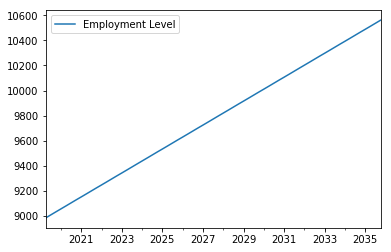

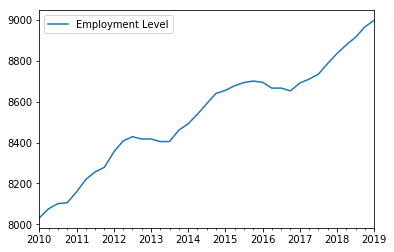

In [15]:
emp_projections = regressor.predict(np.array(mfg_emp_proj['ordinals']).reshape(-1,1))
mfg_emp_proj['Employment Level'] = emp_projections
mfg_emp_proj.plot(y='Employment Level')
mfg_emp.plot(y='Employment Level')

tot_projection_span holds the regression projection for the entire span of 2010 to 2035.


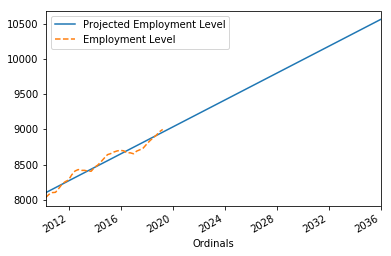

In [16]:
proj_x = np.array(mfg_emp_proj['ordinals']).reshape(-1,1)
X_tot = np.concatenate((X, proj_x), axis=0)
emp_proj_tot = regressor.predict(X_tot)

tot_projection_span = pd.DataFrame(X_tot)
tot_projection_span['Projected Employment Level'] = emp_proj_tot
tot_projection_span.columns = ['Ordinals', 'Projected Employment Level']

print('tot_projection_span holds the regression projection for the entire span of 2010 to 2035.')

fig, ax = plt.subplots()
tot_projection_span.plot(x='Ordinals', y='Projected Employment Level', ax=ax)
mfg_emp_reg.plot(y='Employment Level', ax=ax, ls='--')
plt.savefig('actual_w_regline.png')
plt.show()


In [17]:
print(tot_projection_span.tail(1))

     Ordinals  Projected Employment Level
103    743268                 10560.42556


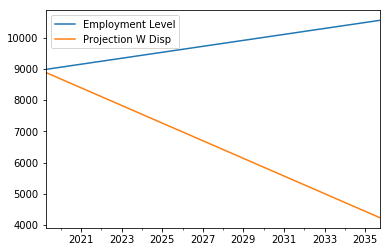

In [18]:
displacement_tot = (tot_projection_span['Projected Employment Level'][103]*.6)
displacement_increment = displacement_tot/len(mfg_emp_proj)
cumulative_disp = np.cumsum(np.repeat(displacement_increment, len(mfg_emp_proj)))
mfg_emp_proj['Projection W Disp'] = mfg_emp_proj['Employment Level']-cumulative_disp

fig, ax = plt.subplots()
mfg_emp_proj.plot(y='Employment Level', ax=ax)
mfg_emp_proj.plot(y='Projection W Disp', ax=ax)

In [19]:
tot_projection_span.set_index([pd.date_range(start='01/01/2010', end='01/01/2036', freq='Q')], inplace=True)
tot_projection_span[:'04/01/2019'].head()

,Ordinals,Projected Employment Level
2010-03-31,733862,8100.156674
2010-06-30,733953,8123.958978
2010-09-30,734045,8148.022845
2010-12-31,734137,8172.086713
2011-03-31,734227,8195.627453


In [21]:
t1 = tot_projection_span['Projected Employment Level']['01/01/2010':'04/01/2019']
t2 = mfg_emp_proj['Projection W Disp']['04/01/2019':]
disp_proj_hist = pd.Series(t1).append(t2)
tot_projection_span['With Displacement'] = disp_proj_hist

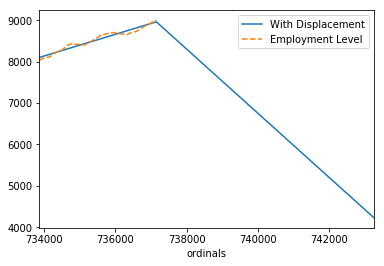

In [22]:
fig, ax = plt.subplots()
tot_projection_span.plot(x='Ordinals', y='With Displacement', ax=ax)
mfg_emp_reg.plot(x='ordinals', y='Employment Level', ax=ax, ls='--')

plt.show()


In [23]:
tot_projection_span.to_csv('tot_projection_span.csv', sep='\t', encoding='utf-8')

In [24]:
nat_emp_reg = nat_emp.copy()
nat_emp_reg['ordinals'] = nat_emp_reg.index
nat_emp_reg['ordinals'] = nat_emp_reg['ordinals'].apply(lambda x: x.toordinal())

X = np.array(nat_emp_reg['ordinals']).reshape(-1,1)

y = nat_emp_reg['National Employment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

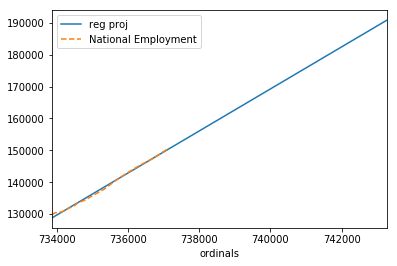

In [25]:
daterange=pd.date_range(start='01/01/2010', end='01/01/2036', freq='Q')
totord = pd.Series(daterange).apply(lambda x: x.toordinal())

tot_nat_pred = regressor.predict(np.array(totord).reshape(-1,1))
nat_tot_projection = pd.DataFrame()
nat_tot_projection['ordinals'] = np.array(totord)
nat_tot_projection['reg proj'] = tot_nat_pred
nat_tot_projection.set_index([daterange], inplace=True)

fig, ax = plt.subplots()
nat_tot_projection.plot(x='ordinals', y='reg proj', ax=ax)
nat_emp_reg.plot(x='ordinals', y='National Employment', ax=ax, ls='--')

From 1980 to 2007, total employment in the U.S. grew
by 17.5%. About half (8.84%) of this growth is explained by the additional employment growth in new jobs. (2016). For the purposes of estimating new job creation, this historical share of the total growth will be held constant as an extraplotor for estimating what share of employment growth is due to new job creation.

In [26]:
hist_growth = .175
new_job = .0884
nj_pct_tot = new_job/hist_growth
nj_pct_tot

0.5051428571428572

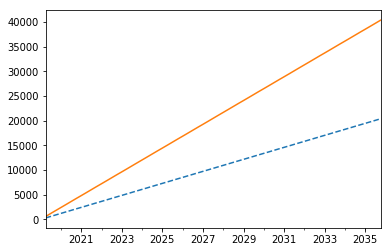

In [27]:
test = nat_tot_projection['01/01/2019':][:]
test['level change'] = test['reg proj'].diff()
test['new jobs'] = test['level change'] * nj_pct_tot

cum_new_jobs = np.cumsum(test['new jobs']['04/01/2019':])
cum_tot_jobs = np.cumsum(test['level change']['04/01/2019':])

fig, ax = plt.subplots()
cum_new_jobs.plot(ax=ax, ls='--')
cum_tot_jobs.plot(ax=ax)

In [89]:
print(cum_new_jobs[-1], cumulative_disp[-1])
print('\n')
print('Cumulative new jobs at national level less manufacturing displacement in 2035:\n{}'.format(cum_new_jobs[-1]-cumulative_disp[-1]))
print('The percentage of new job creation absorbed by mfg displacement: {}'.format(cumulative_disp[-1]/cum_new_jobs[-1]))

20370.174549880692 6336.255335975006


Cumulative new jobs at national level less manufacturing displacement in 2035:
14033.919213905687
The percentage of new job creation absorbed by mfg displacement: 0.3110555248537189


The above forecasts new job creation at the national level, the level of displaced manufacturing jobs, and the level of new jobs left after absorbing manufacturing displcement. The next step is compute the income lost within manufacturing due to displacement.

In [53]:
mfg_labor_cost.tail()

,avg hourly wage,avg weekly hours,total weekly cost
2018-03-31,21.340000,42.100000,898.419000
2018-06-30,21.456667,42.166667,904.757333
2018-09-30,21.543333,42.166667,908.408000
2018-12-31,21.773333,42.033333,915.203000
2019-03-31,21.896667,41.800000,915.276000


In [81]:
mfg_labor_reg = mfg_labor_cost.copy()
mfg_labor_reg['ordinals'] = mfg_labor_reg.index
mfg_labor_reg['ordinals'] = mfg_labor_reg['ordinals'].apply(lambda x: x.toordinal())

X = np.array(mfg_labor_reg['ordinals']).reshape(-1,1)

y = mfg_labor_reg['avg hourly wage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [82]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))


Linear Regression R squared": 0.9275


In [86]:
wage_pred = regressor.predict(np.array(totord).reshape(-1,1))
wage_pred = pd.Series(wage_pred)
wage_proj = pd.DataFrame()
wage_proj['Wage Projection'] = wage_pred
wage_per_lab_lost = pd.DataFrame()
wage_per_lab_lost = wage_proj*40
total_income_lost = np.array(wage_per_lab_lost * 6336)
total_income_lost

array([[4630217.78022919],
       [4652985.3182902 ],
       [4676003.04907718],
       [4699020.77986416],
       [4721538.12519926],
       [4744305.66326027],
       [4767323.39404725],
       [4790341.12483423],
       [4813108.66289526],
       [4835876.2009563 ],
       [4858893.93174328],
       [4881911.66253026],
       [4904429.00786533],
       [4927196.54592637],
       [4950214.27671334],
       [4973232.00750032],
       [4995749.35283539],
       [5018516.89089643],
       [5041534.62168341],
       [5064552.35247039],
       [5087069.69780548],
       [5109837.23586649],
       [5132854.96665347],
       [5155872.69744045],
       [5178640.23550149],
       [5201407.77356253],
       [5224425.50434951],
       [5247443.23513646],
       [5269960.58047155],
       [5292728.11853259],
       [5315745.84931957],
       [5338763.58010655],
       [5361280.92544162],
       [5384048.46350266],
       [5407066.19428963],
       [5430083.92507661],
       [5452601.27041168],
 